# How to determine if a dataset is enough to train a machine learning model?

Not every problem can be solved using machine learning. Here, we show an example of a dataset that using it alone in a machine learning model, it will result in deficient machine learning models.

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import numpy as np
import geopy.distance 
import matplotlib.pyplot as plt


from sklearn.feature_selection import mutual_info_regression

In [37]:
def distance(row):
    c_1 = (row['pickup_latitude'],row['pickup_longitude'])
    c_2 = (row['dropoff_latitude'],row['dropoff_longitude'])
    dist_c1_c2 = geopy.distance.geodesic(c_1,c_2).km
    return dist_c1_c2

The dataset contains information about [UBER fares](https://www.kaggle.com/datasets/yasserh/uber-fares-dataset) retrieved from Kaggle.

The target variable will be ```fare_amount```.


In [38]:
d = pd.read_csv('/content/drive/MyDrive/uber.csv')
d.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [39]:
df = d.copy()
df.dropna(inplace=True)

The variable ```key``` is a timestamp. We split it into all its parts.

In [40]:
df['date'] = pd.to_datetime(df['key'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute


There are several outliers. We drop almost all of them because their values do not correspond to possible data (the geographic coordinates are not consistent).

In [41]:
df = df.drop(['pickup_datetime','Unnamed: 0','key','date'],axis=1)
df = df.drop(index=df[df['passenger_count']==208].index[0])
df =df[(abs(df['pickup_longitude'])<180)&
       (abs(df['pickup_latitude'])<90)&
       (abs(df['dropoff_longitude'])<180)&
       (abs(df['dropoff_latitude'])<90)]
df = df[(df['pickup_longitude']!=0)&(df['pickup_latitude']!=0)&(df['dropoff_longitude']!=0)&(df['dropoff_latitude']!=0)]

We add the distance between pickup and dropoff locations. According to distance and fare amount, we consider as outliers those samples under the 5% quantile and above the 95% quantile.

In [42]:
df['distance']=df.apply(distance,axis=1)

upper = df.quantile(q=.95)
lower = df.quantile(q=.05)

quantiles_d = [lower.loc['distance'],upper.loc['distance']]
quantiles_f = [lower.loc['fare_amount'],upper.loc['fare_amount']]

df = df[(df['distance']<quantiles_d[1])&(df['distance']>quantiles_d[0])&(df['fare_amount']<quantiles_f[1])&(df['fare_amount']>quantiles_f[0])]

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,1.681111
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,2.454363
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,5.039603
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,1.661442
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,4.483730


#Is this dataset adequate for fare prediction through Machine Learning?

We determine if this sole dataset has enough information to successfully apply machine learnig in order to predict the fare amount of an uber trip.

The tools we use are: Pearson Correlation and Mutual Information

1.   Elemento de lista
2.   Elemento de lista



##Pearson correlation

We calculate the Pearson correlation of our dataset; as we can see in the series below, the only feature that has significant correlation with fare amount is the one we created: distance.

We also provide a chart to visualize the correlation matrix.

Thus, from the point of view of the Pearson correlation coefficient, distance is the only candidate to use as a feature in a machine learning model.

In [43]:
df.corr()['fare_amount']

fare_amount          1.000000
pickup_longitude     0.010833
pickup_latitude     -0.010047
dropoff_longitude    0.011749
dropoff_latitude    -0.010599
passenger_count      0.009409
year                 0.136669
month                0.029950
day                  0.003662
hour                -0.019914
minute              -0.005169
distance             0.838753
Name: fare_amount, dtype: float64

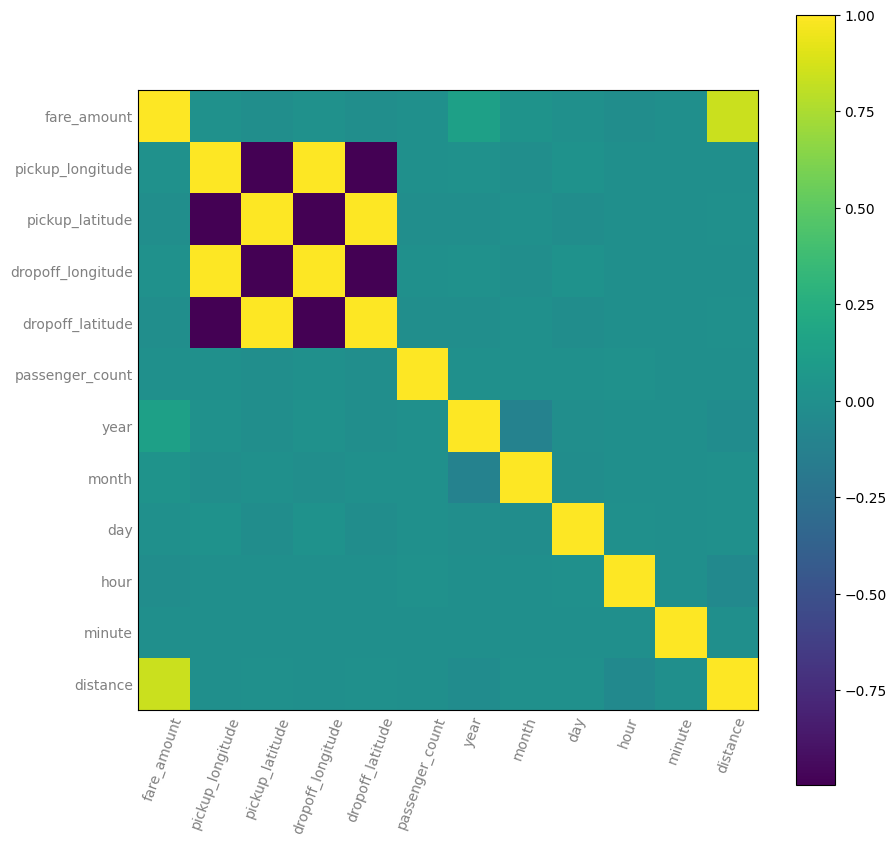

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(df.corr())
pos =np.arange(df.shape[1])

plt.xticks(ticks=pos,labels=df.columns)

plt.yticks(ticks=pos,labels=df.columns)

plt.gca().tick_params(axis='both', which='both',length=0,labelcolor='gray')

x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(70)

plt.colorbar()

##Mutual information

Calculating the [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) of all features with respect to the fare amount, we see that there are only two features (year and, again, distance) that could be consider as informative for a machine learning model.


However, their mutual information values are low. Let us see why.

In [45]:
targets = df['fare_amount']
samples = df.drop('fare_amount',axis=1)

pd.Series(mutual_info_regression(samples,targets),index=samples.columns,name='MI')

pickup_longitude     3.191680e-02
pickup_latitude      3.132157e-02
dropoff_longitude    5.450552e-02
dropoff_latitude     5.663106e-02
passenger_count      6.584700e-03
year                 4.526392e-01
month                1.459858e-02
day                  1.193549e-07
hour                 8.096861e-03
minute               0.000000e+00
distance             6.863674e-01
Name: MI, dtype: float64

##Year vs fare
The mutual information and correlation coefficient of year and fare amount are higher than the corresponding values of other features. However, we do not consider year as a relevant feature. We explain why.

If we attempt to implement a machine learning model for real data, we do not expect year to be relevant because new data will have a year not seen by our model.

Also, there are economic factors that this dataset does not contains. For example, in the chart below we can see that the mean value of fares in each month increases with the year. Although this explains why the mutual information and correlation coefficient of year and fare are high, there is a singularity in the chart. In 2012 fares rised and kept that high in subsequent years. This fenomenom could be explained by the expansion of [UBER](https://www.uber.com/newsroom/history/).

In addition, maybe adjusting by inflation will cause a deacrease in the mutual information value.

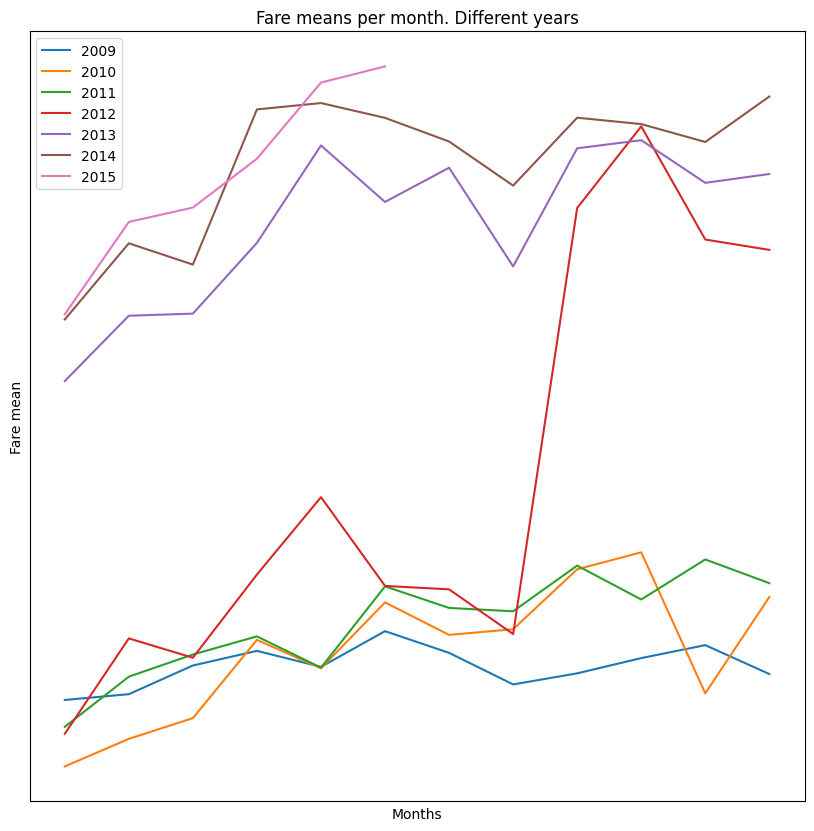

In [46]:
plt. figure(figsize=(10,10))

df = df.sort_values(by='year')
means = df.groupby(['year','month']).mean()
means = means['fare_amount']

plt.title('Fare means per month. Different years')

for yr in df['year'].unique():
  plt.plot(means.loc[yr],label=yr)

plt.xlabel('Months')
plt.ylabel('Fare mean')

plt.yticks(ticks=[])
plt.xticks(ticks=[])

plt.gca().tick_params(axis='both', which='both',length=0,labelcolor='gray')

plt.legend(loc='upper left')

##Fare vs distance

Although distance got the highest score in both metrics, we do not consider it as relevant. As we can see in the scatter plot below pairs $(distance,fare)$ are distributed homogenously on the plane. Thus, any regression model will overlook many data because its approximation function cannot cover the plane.

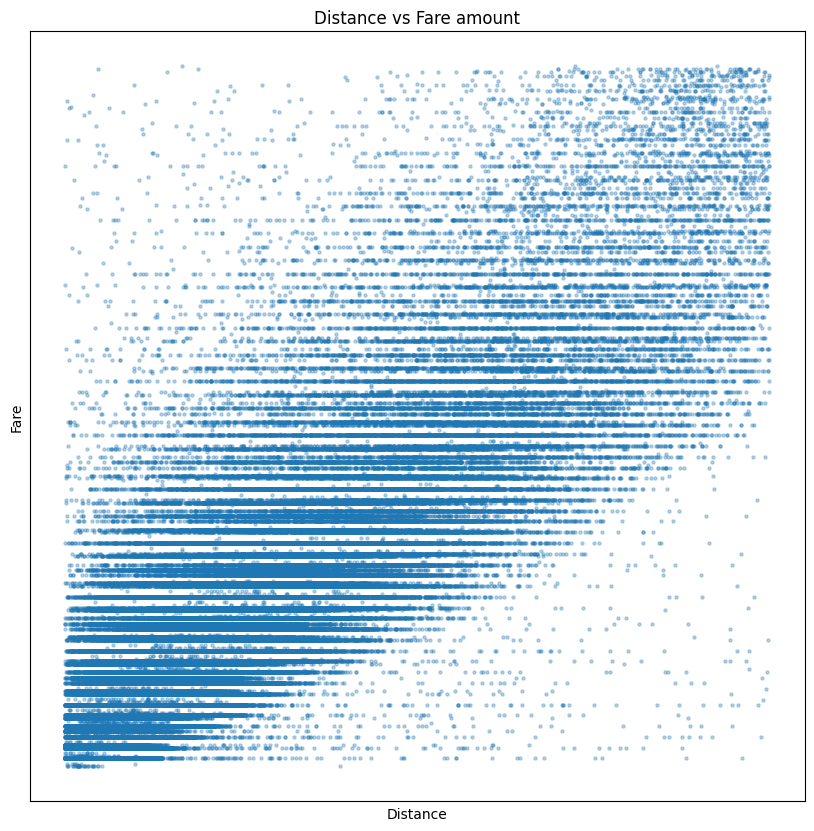

In [47]:
plt.figure(figsize=(10,10))

plt.yticks(ticks=[])

plt.xticks(ticks=[])

plt.gca().tick_params(axis='x', which='both',length=0,labelcolor='gray')

plt.xlabel('Distance')
plt.ylabel('Fare')

plt.title('Distance vs Fare amount')

plt.scatter(df['distance'],df['fare_amount'],alpha=.3,s=5)

#Summary

The dataset we presented is not enough to train a good machine learning model. However, this does not mean that the fare amount prediction cannot be solved with machine learning. 

In order to use machine learning to solve this particular task, we need to collect different data. E.g. economic indicators, wheather, new information about UBER fares. In addition to that estrategy, we could generate features just as we did with distance. For example, we could use polynomial transformations or another technique that modifies the geometry of our data (to avoid its uniformity on the space).